In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov9-main

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/MyDrive/yolov9-main


In [2]:
!python --version

Python 3.12.11


In [ ]:
# --- Step 1: Install Python 3.11 in Colab ---
!sudo apt-get update -y
!sudo apt-get install -y python3.11 python3.11-distutils python3.11-venv

# --- Step 2: Make sure pip for 3.11 exists ---
!curl -sS https://bootstrap.pypa.io/get-pip.py | python3.11

# --- Step 3: Upgrade pip + wheel + setuptools (important for old packages) ---
!python3.11 -m pip install --upgrade pip setuptools wheel certifi

# --- Step 4: Install your packages using Python 3.11 explicitly ---
!python3.11 -m pip install torch==2.0.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

!git clone https://github.com/open-mmlab/mim.git
%cd mim
!python3.11 -m pip install -e .
%cd ..

!python3.11 -m pip install openmim
!python3.11 -m mim install "mmengine>=0.7.4" \
    "mmcv==2.1.0" --trusted-host download.openmmlab.com

In [ ]:
# Clone MMDetection & install
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!python3.11 -m pip install -e .
%cd ..

In [7]:
# STEP 5: Final check
!python3.11 -c "import torch; import mmcv; import mmdet; print('PyTorch:', torch.__version__); print('MMCV:', mmcv.__version__); print('MMDet:', mmdet.__version__)"

PyTorch: 2.0.1+cu117
MMCV: 2.1.0
MMDet: 3.3.0


In [ ]:
!python3.11 -m pip install numpy==1.25.2

In [ ]:
!python3.11 -m pip install git+https://github.com/cocodataset/panopticapi.git

In [10]:
!ls mmdetection/configs/panoptic_fpn/

metafile.yml			     panoptic-fpn_r50_fpn_1x_coco.py
panoptic-fpn_r101_fpn_1x_coco.py     panoptic-fpn_r50_fpn_ms-3x_coco.py
panoptic-fpn_r101_fpn_ms-3x_coco.py  README.md


In [28]:
!MPLBACKEND=Agg python3.11 mmdetection/demo/image_demo.py \
    /content/gdrive/MyDrive/Hugging\ Face/datasets/vitpose_models/elephant-giraffe.jpg \
    mmdetection/configs/panoptic_fpn/panoptic-fpn_r101_fpn_ms-3x_coco.py \
    --weights mmdetection/mmdet_outputs/panoptic_fpn_r101_fpn_mstrain_3x_coco_20210823_114712-9c99acc4.pth \
    --out-dir mmdetection/mmdet_outputs/pan_results/pan_seg_exp2

Loads checkpoint by local backend from path: mmdetection/mmdet_outputs/panoptic_fpn_r101_fpn_mstrain_3x_coco_20210823_114712-9c99acc4.pth
/content/gdrive/MyDrive/yolov9-main/mmdetection/mmdet/models/losses/cross_entropy_loss.py:240: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
08/23 09:52:56 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
/usr/local/lib/python3.11/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'

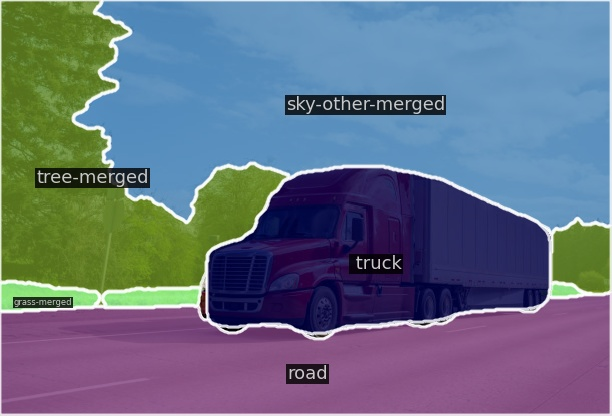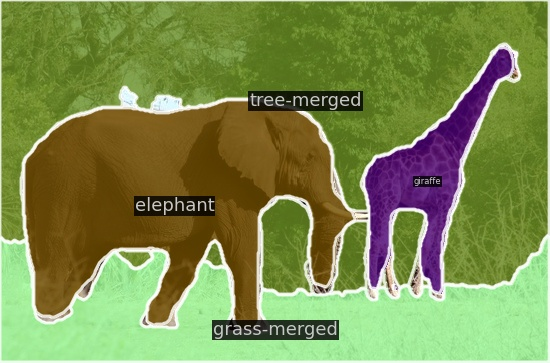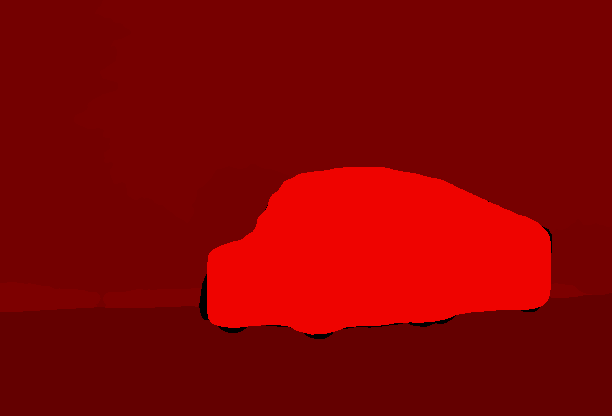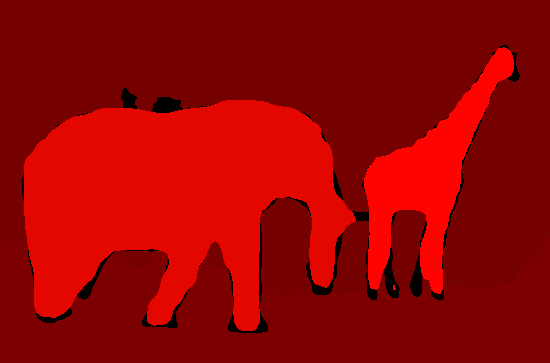

In [73]:
%%writefile infer_panoptic.py
import os
os.environ["MPLBACKEND"] = "agg"
import glob
import cv2
from mmengine.config import Config
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
import mmcv
import numpy as np

# ----------------- User paths -----------------
# Can be a folder or a single image file
input_path = "/content/gdrive/MyDrive/Hugging Face/datasets/vitpose_models/zebra-horse.jpg"
out_folder = "mmdetection/mmdet_outputs/pan_results/pan_seg_exp3"

config_file = "mmdetection/configs/panoptic_fpn/panoptic-fpn_r101_fpn_ms-3x_coco.py"
checkpoint_file = "mmdetection/mmdet_outputs/panoptic_fpn_r101_fpn_mstrain_3x_coco_20210823_114712-9c99acc4.pth"

os.makedirs(out_folder, exist_ok=True)

# ----------------- Initialize model -----------------
register_all_modules()
model = init_detector(config_file, checkpoint_file, device="cuda:0")

# ----------------- Prepare images -----------------
if os.path.isdir(input_path):
    img_list = glob.glob(os.path.join(input_path, "*.*"))
elif os.path.isfile(input_path):
    img_list = [input_path]
else:
    raise ValueError(f"Input path does not exist: {input_path}")

# ----------------- Inference + visualization -----------------
for img_path in img_list:
    print("Processing:", img_path)
    img = mmcv.imread(img_path)
    result = inference_detector(model, img_path)

    # extract panoptic mask
    pan_mask = result.pred_panoptic_seg.sem_seg.squeeze(0).cpu().numpy()  # shape HxW

    # make safe palette
    max_label = pan_mask.max() + 1
    palette = np.random.randint(0, 256, size=(max_label, 3), dtype=np.uint8)
    color_mask = palette[pan_mask]

    # resize original image to mask size
    img_resized = cv2.resize(img, (pan_mask.shape[1], pan_mask.shape[0]))

    # blend
    vis = cv2.addWeighted(img_resized, 0.4, color_mask, 0.6, 0)

    # save
    out_file = os.path.join(out_folder, os.path.basename(img_path))
    cv2.imwrite(out_file, vis)
    print(f"Saved: {out_file}")

print("Inference + visualization complete ✅")

Overwriting infer_panoptic.py


In [74]:
!python3.11 infer_panoptic.py

/content/gdrive/MyDrive/yolov9-main/mmdetection/mmdet/models/losses/cross_entropy_loss.py:240: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Loads checkpoint by local backend from path: mmdetection/mmdet_outputs/panoptic_fpn_r101_fpn_mstrain_3x_coco_20210823_114712-9c99acc4.pth
Processing: /content/gdrive/MyDrive/Hugging Face/datasets/vitpose_models/zebra-horse.jpg
Saved: mmdetection/mmdet_outputs/pan_results/pan_seg_exp3/zebra-horse.jpg
Inference + visualization complete ✅


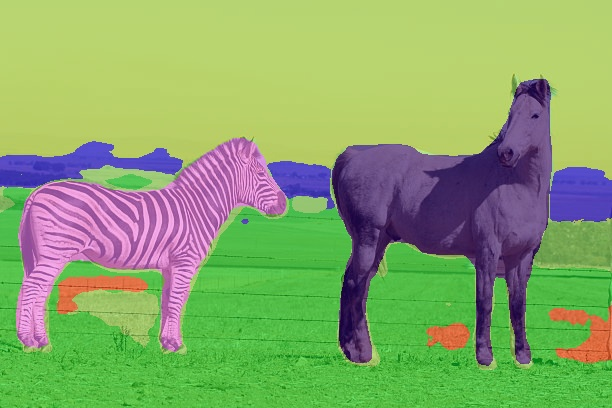

In [75]:
!MPLBACKEND=Agg python3.11 mmdetection/demo/image_demo.py \
    /content/gdrive/MyDrive/Hugging\ Face/datasets/panoptic-tests \
    mmdetection/configs/panoptic_fpn/panoptic-fpn_r101_fpn_ms-3x_coco.py \
    --weights mmdetection/mmdet_outputs/panoptic_fpn_r101_fpn_mstrain_3x_coco_20210823_114712-9c99acc4.pth \
    --out-dir mmdetection/mmdet_outputs/pan_results/pan_seg_exp4

Loads checkpoint by local backend from path: mmdetection/mmdet_outputs/panoptic_fpn_r101_fpn_mstrain_3x_coco_20210823_114712-9c99acc4.pth
/content/gdrive/MyDrive/yolov9-main/mmdetection/mmdet/models/losses/cross_entropy_loss.py:240: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
08/23 12:03:50 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
/usr/local/lib/python3.11/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'

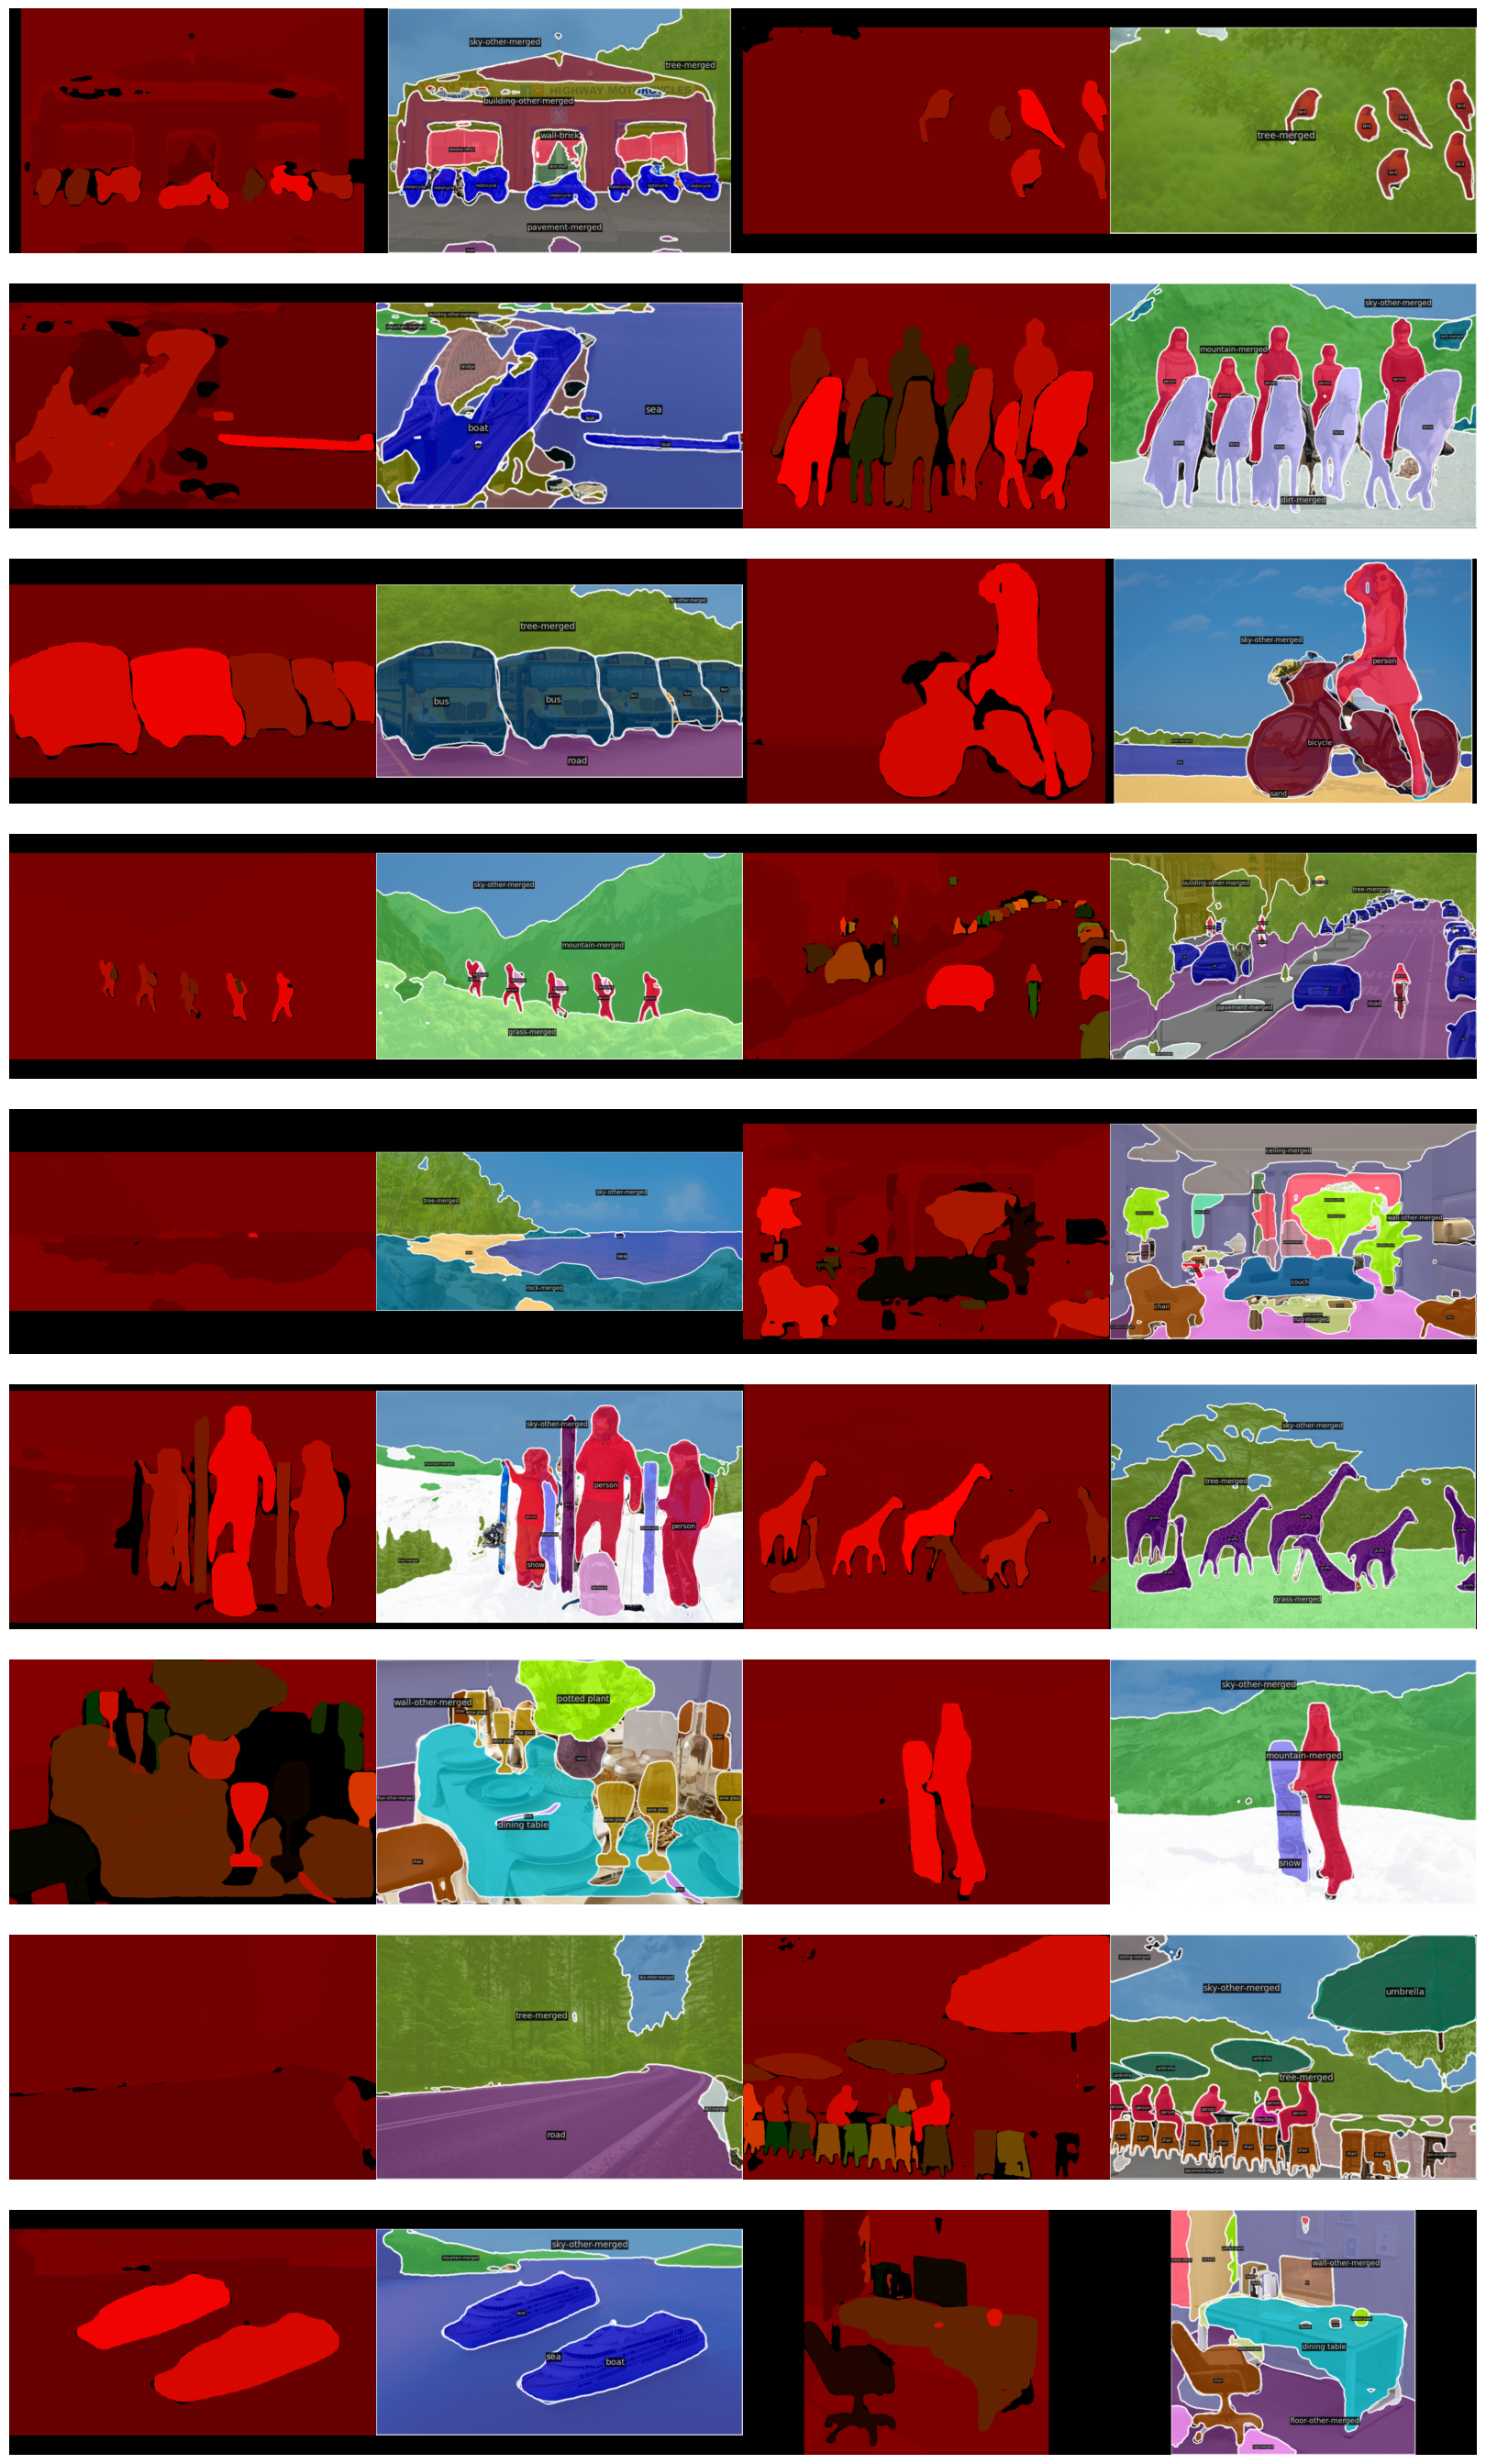

In [77]:
import os
import cv2
import random
import matplotlib.pyplot as plt

results_dir = "mmdetection/mmdet_outputs/pan_results/pan_seg_exp4"
vis_dir = os.path.join(results_dir, "vis")
preds_dir = os.path.join(results_dir, "preds")

# --------------------------
# Collect images
# --------------------------
all_vis_imgs = [f for f in os.listdir(vis_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

processed_imgs = []

for vis_fname in all_vis_imgs:
    base_name = os.path.splitext(vis_fname)[0]
    vis_path = os.path.join(vis_dir, vis_fname)
    pred_path = os.path.join(preds_dir, f"{base_name}_panoptic_seg.png")

    if not os.path.exists(pred_path):
        continue  # skip if corresponding preds image is missing

    vis_img = cv2.imread(vis_path)[..., ::-1]  # BGR→RGB
    pred_img = cv2.imread(pred_path)[..., ::-1]

    processed_imgs.append((pred_img, vis_img))  # (instance, panoptic)

# --------------------------
# Prepare for grid plot
# --------------------------
cols = 4  # 2 images x 2 visuals per row
rows = (len(processed_imgs) + 1) // 2  # 2 images per row

plt.figure(figsize=(4 * cols, 3 * rows))

# Target display size for each grid cell
target_height = 720
target_width = 1080

for idx, (instance_result, panoptic_result) in enumerate(processed_imgs):
    for view_idx, view in enumerate([instance_result, panoptic_result]):
        h, w = view.shape[:2]

        # Scale keeping aspect ratio
        scale = min(target_width / w, target_height / h)
        new_w, new_h = int(w * scale), int(h * scale)
        resized = cv2.resize(view, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # Pad to target size
        top = (target_height - new_h) // 2
        bottom = target_height - new_h - top
        left = (target_width - new_w) // 2
        right = target_width - new_w - left
        padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

        plot_idx = idx * 2 + view_idx + 1
        plt.subplot(rows, cols, plot_idx)
        plt.imshow(padded)
        plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()